In [1]:
import itertools as it

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import scipy
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
teeplot_subdir = "adaptive-evolution-rate.ipynb"


In [3]:
def load_and_process(url: str, mutation: str) -> pl.DataFrame:
    df = pl.read_parquet(
        url,
        use_pyarrow=True,
    ).group_by(
        ["Task", "Treatment", "Run ID", "Generation Born"],
    ).first().with_columns(
        pl.col("Task").replace_strict(
            {
                "AND": 2,
                "ANDNOT": 3,
                "NAND": 1,
                "NOR": 4,
                "NOT": 1,
                "OR": 3,
                "ORNOT": 2,
                "XOR": 4,
                "EQUALS": 5,
            },
        ).alias("Components"),
        pl.lit(mutation).alias("Mutation"),
    )

    return df


In [4]:
df1 = load_and_process("https://osf.io/emh23/download", "poisson")


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


In [5]:
df2 = load_and_process("https://osf.io/gk2ty/download", "per site")


In [6]:
df = pl.concat([df1, df2])


In [7]:
dfz = df.filter(
    pl.col("has task")
).group_by(
    ["Task", "Treatment", "Run ID", "Components", "Mutation"],
).agg(
    pl.col("Generation Born").min(),
)


In [8]:
maxgen = dfz["Generation Born"].max()

records = []
records2 = set()
for row in dfz.iter_rows(named=True):
    records.append(
        pd.DataFrame(
            {
                "Task": row["Task"],
                "Treatment": row["Treatment"],
                "Run ID": row["Run ID"],
                "Generation": np.arange(maxgen),
                "Components": row["Components"],
                "Has Task":  row["Generation Born"] <= np.arange(maxgen),
                "mutation": row["Mutation"],
            },
        ),
    )
    records2.add(
        (row["Run ID"], row["Treatment"], row["Task"], row["Components"], row["Mutation"]),
    )

for v, grp in df.to_pandas().groupby(
    ["Run ID", "Treatment", "Task", "Components", "Mutation"],
    observed=True,
):
    if v not in records2:
        print(v)
        records.append(
            pd.DataFrame(
                {
                    "Task": v[2],
                    "Treatment": v[1],
                    "Run ID": v[0],
                    "Components": v[3],
                    "Generation": np.arange(maxgen),
                    "Has Task":  False,
                    "mutation": v[4],
                },
            ),
        )

dfz_ = pd.concat(records, ignore_index=True)


('run_1770', 'Slip-_Long', 'ANDNOT', np.int64(3), 'poisson')
('run_1770', 'Slip-_Long', 'EQUALS', np.int64(5), 'poisson')
('run_1770', 'Slip-_Long', 'NOR', np.int64(4), 'poisson')
('run_1770', 'Slip-_Long', 'XOR', np.int64(4), 'poisson')
('run_1771', 'Slip-_Long', 'AND', np.int64(2), 'poisson')
('run_1771', 'Slip-_Long', 'ANDNOT', np.int64(3), 'poisson')
('run_1771', 'Slip-_Long', 'EQUALS', np.int64(5), 'poisson')
('run_1771', 'Slip-_Long', 'NOR', np.int64(4), 'poisson')
('run_1771', 'Slip-_Long', 'OR', np.int64(3), 'poisson')
('run_1771', 'Slip-_Long', 'XOR', np.int64(4), 'poisson')
('run_1772', 'Slip-_Long', 'AND', np.int64(2), 'poisson')
('run_1772', 'Slip-_Long', 'ANDNOT', np.int64(3), 'poisson')
('run_1772', 'Slip-_Long', 'EQUALS', np.int64(5), 'poisson')
('run_1772', 'Slip-_Long', 'NOR', np.int64(4), 'poisson')
('run_1772', 'Slip-_Long', 'NOT', np.int64(1), 'poisson')
('run_1772', 'Slip-_Long', 'OR', np.int64(3), 'poisson')
('run_1772', 'Slip-_Long', 'XOR', np.int64(4), 'poisson'

('run_1844', 'Slip+', 'XOR', np.int64(4), 'poisson')
('run_1845', 'Slip+', 'EQUALS', np.int64(5), 'poisson')
('run_1845', 'Slip+', 'XOR', np.int64(4), 'poisson')
('run_1848', 'Slip+', 'XOR', np.int64(4), 'poisson')
('run_1849', 'Slip+', 'EQUALS', np.int64(5), 'poisson')
('run_1851', 'Slip+', 'EQUALS', np.int64(5), 'poisson')
('run_1851', 'Slip+', 'XOR', np.int64(4), 'poisson')
('run_1852', 'Slip+', 'EQUALS', np.int64(5), 'poisson')
('run_1854', 'Slip+', 'XOR', np.int64(4), 'poisson')
('run_1858', 'Slip+', 'XOR', np.int64(4), 'poisson')
('run_1859', 'Slip+', 'EQUALS', np.int64(5), 'poisson')
('run_1859', 'Slip+', 'XOR', np.int64(4), 'poisson')
('run_1530', 'Baseline-Treatment', 'EQUALS', np.int64(5), 'per site')
('run_1530', 'Baseline-Treatment', 'XOR', np.int64(4), 'per site')
('run_1531', 'Baseline-Treatment', 'EQUALS', np.int64(5), 'per site')
('run_1531', 'Baseline-Treatment', 'XOR', np.int64(4), 'per site')
('run_1532', 'Baseline-Treatment', 'EQUALS', np.int64(5), 'per site')
('run

teeplots/adaptive-evolution-rate.ipynb/col=task+errorbar=ci+hue=treatment+kind=line+post=plt-xlim-0-600+row=mutation+viz=relplot+x=generation+y=has-task+ext=.pdf


teeplots/adaptive-evolution-rate.ipynb/col=task+errorbar=ci+hue=treatment+kind=line+post=plt-xlim-0-600+row=mutation+viz=relplot+x=generation+y=has-task+ext=.png


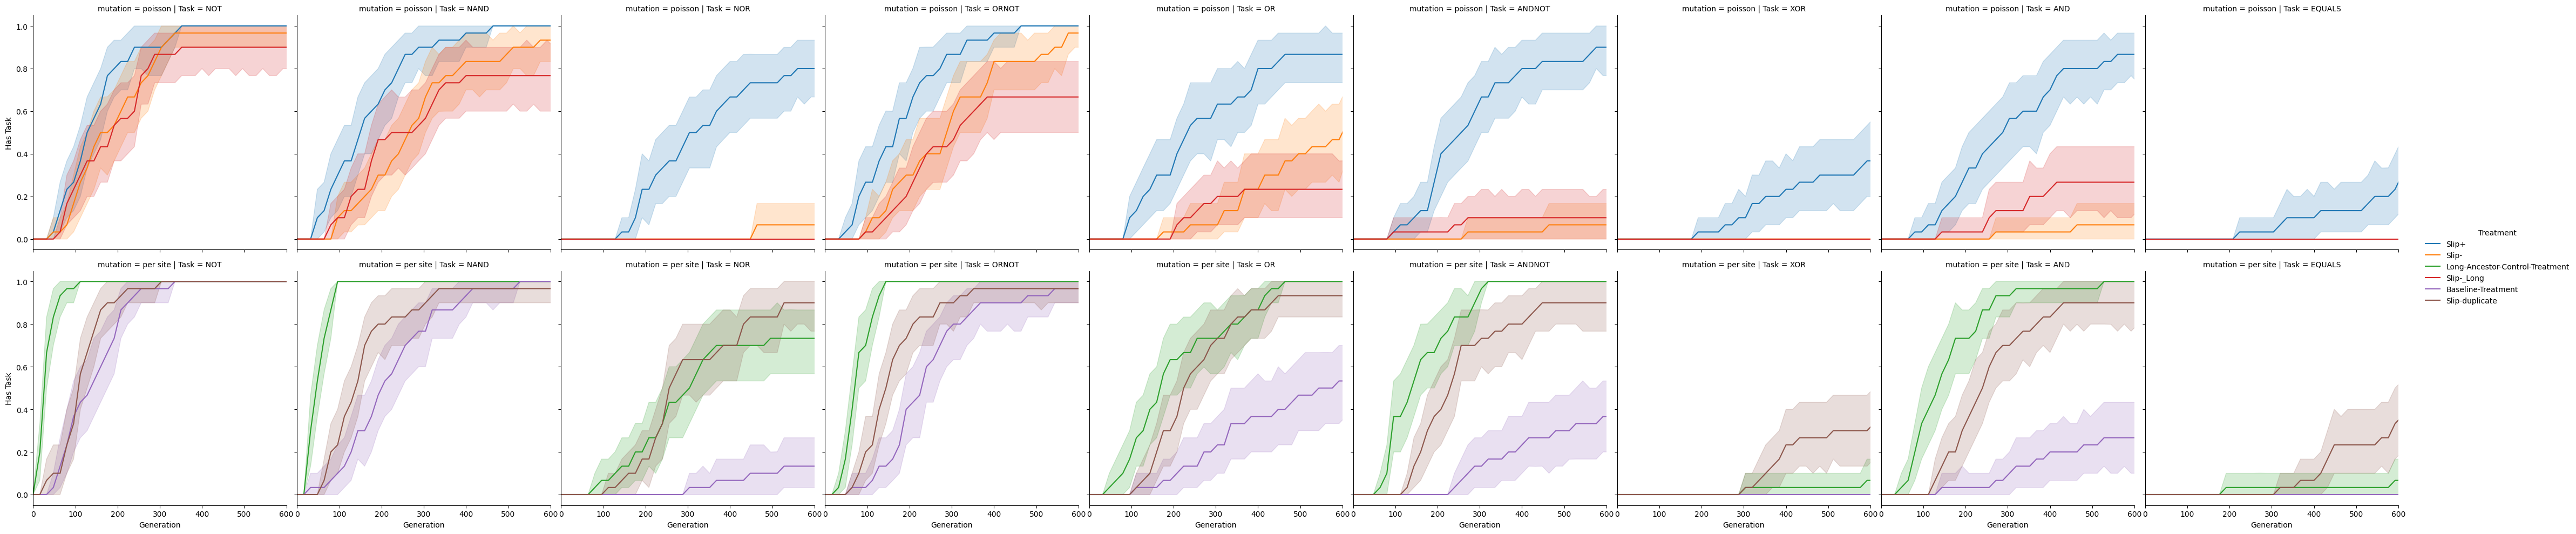

In [9]:
tp.tee(
    sns.relplot,
    data=dfz_[
        dfz_["Generation"] % 16 == 0
    ].reset_index(),
    col="Task",
    row="mutation",
    x="Generation",
    y="Has Task",
    hue="Treatment",
    kind="line",
    errorbar="ci",
    teeplot_postprocess="plt.xlim(0, 600)",
    teeplot_subdir=teeplot_subdir,
)


teeplots/adaptive-evolution-rate.ipynb/col=components+errorbar=ci+hue=treatment+kind=line+post=plt-xlim-0-600+row=mutation+viz=relplot+x=generation+y=has-task+ext=.pdf


teeplots/adaptive-evolution-rate.ipynb/col=components+errorbar=ci+hue=treatment+kind=line+post=plt-xlim-0-600+row=mutation+viz=relplot+x=generation+y=has-task+ext=.png


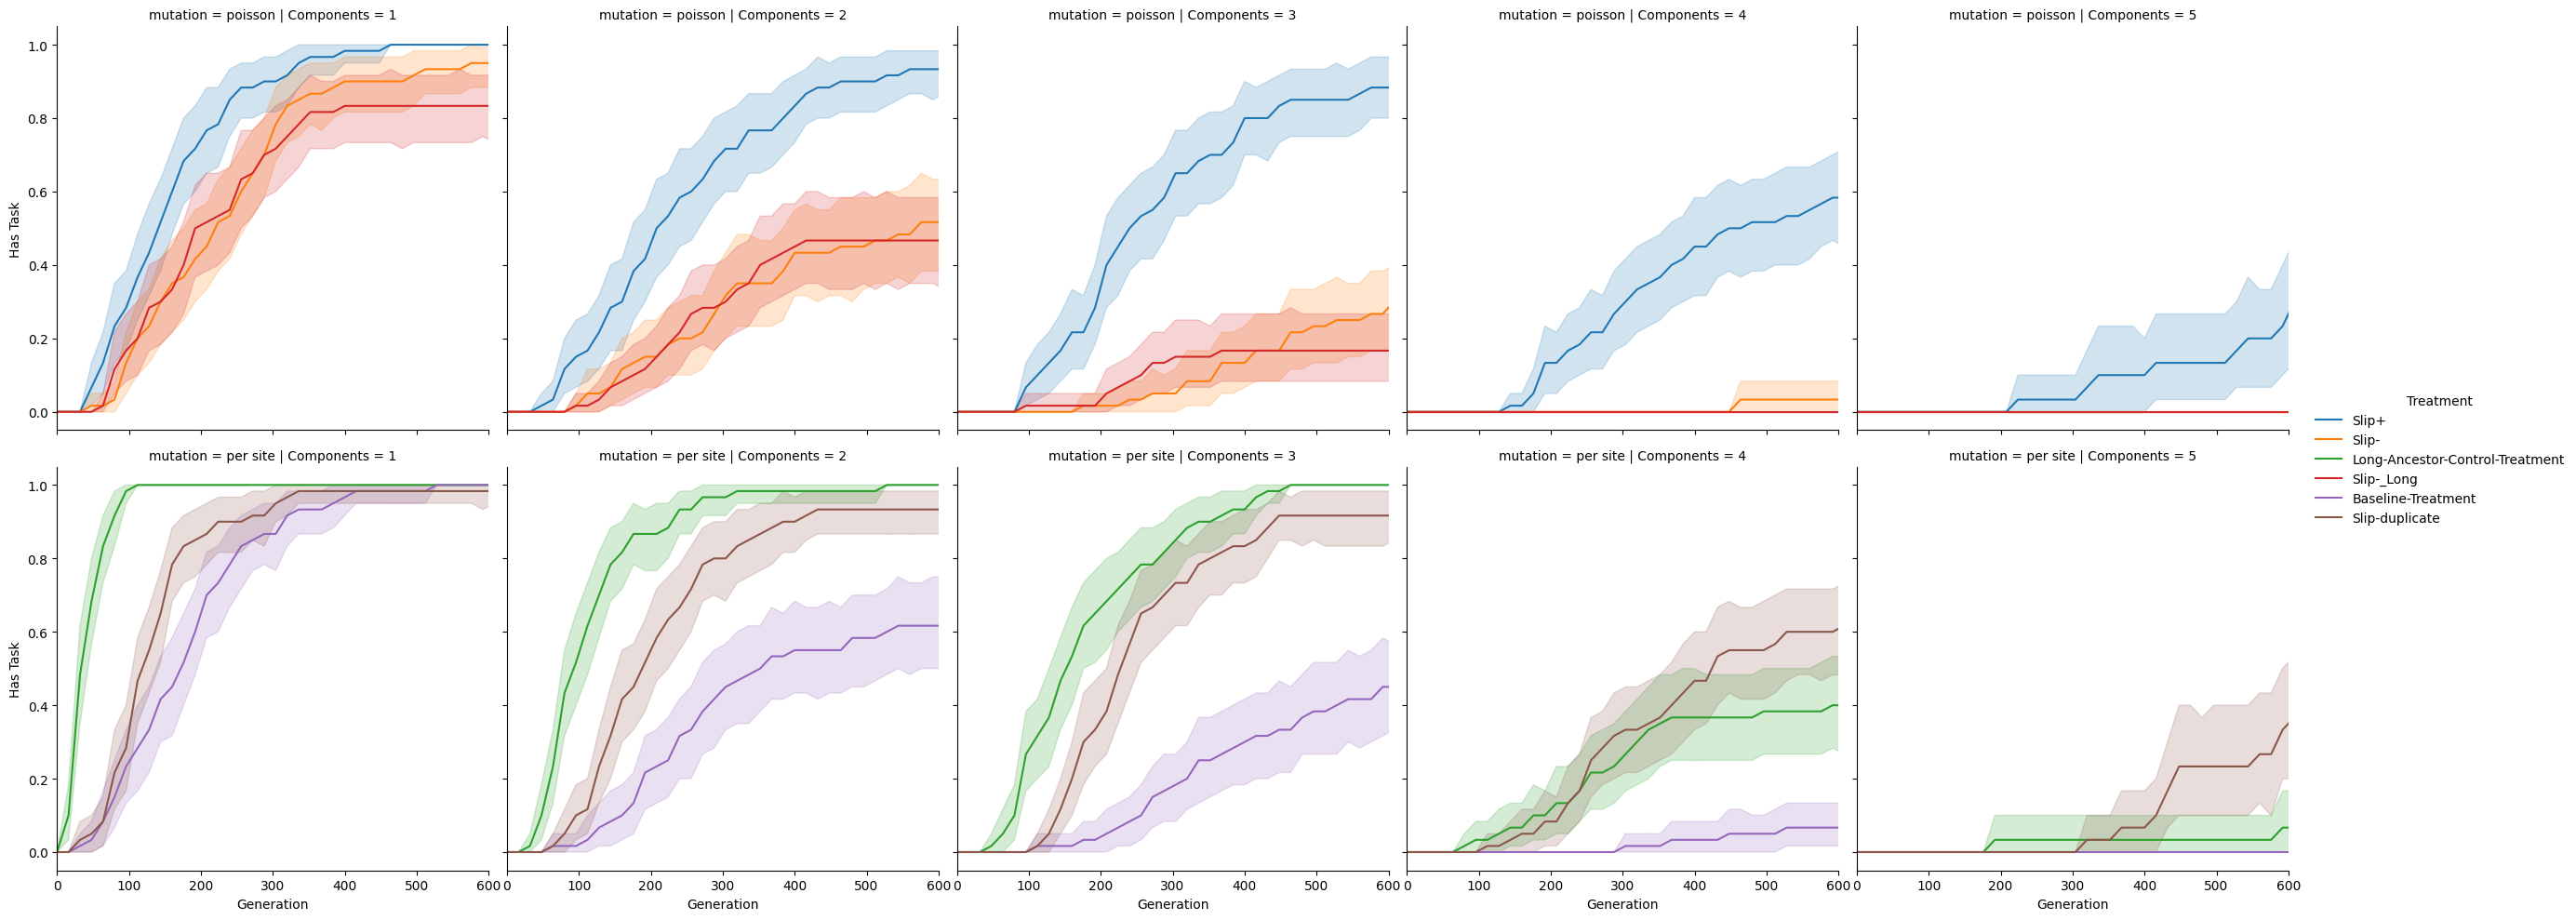

In [10]:
tp.tee(
    sns.relplot,
    data=dfz_[
        dfz_["Generation"] % 16 == 0
    ].reset_index(),
    col="Components",
    row="mutation",
    x="Generation",
    y="Has Task",
    hue="Treatment",
    kind="line",
    errorbar="ci",
    teeplot_postprocess="plt.xlim(0, 600)",
    teeplot_subdir=teeplot_subdir,
)


teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=se+hue=treatment+kind=line+mutation=poisson+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.pdf


teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=se+hue=treatment+kind=line+mutation=poisson+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.png


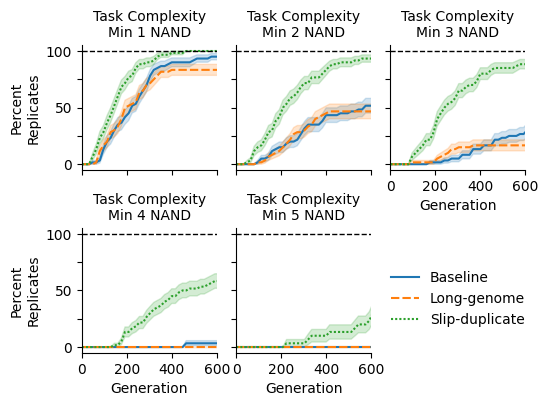

teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=ci+hue=treatment+kind=line+mutation=poisson+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.pdf


teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=ci+hue=treatment+kind=line+mutation=poisson+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.png


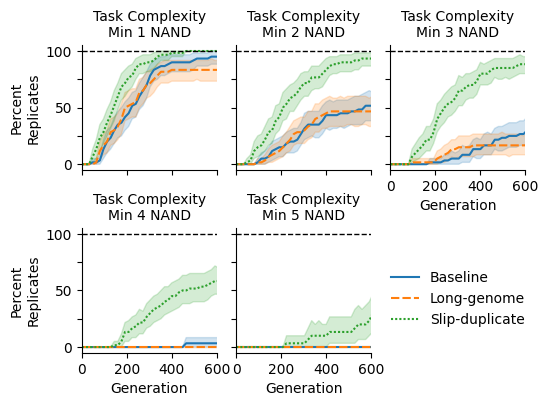

teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=se+hue=treatment+kind=line+mutation=per site+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.pdf


teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=se+hue=treatment+kind=line+mutation=per site+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.png


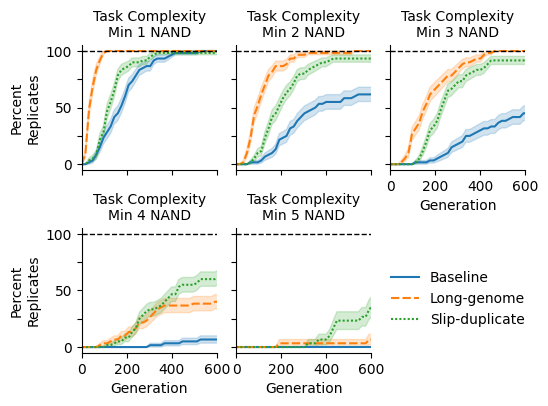

teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=ci+hue=treatment+kind=line+mutation=per site+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.pdf


teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=ci+hue=treatment+kind=line+mutation=per site+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.png


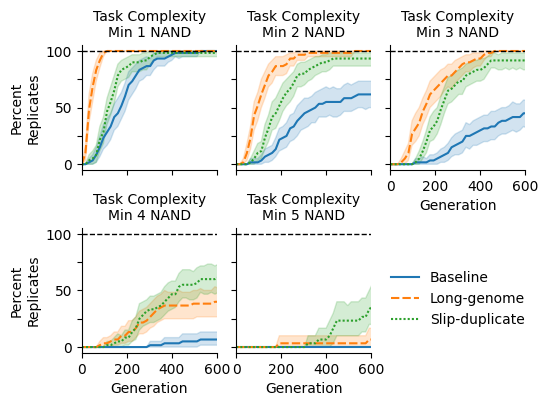

In [11]:
for mutation, errorbar in it.product(
    dfz_["mutation"].unique(),
    ["se", "ci"],
):
    dftmp = dfz_[
        (dfz_["Generation"] % 16 == 0)
        & (dfz_["mutation"] == mutation)
    ].reset_index()
    dftmp["Treatment"] = dftmp["Treatment"].map(
        {
            "Slip-": "Baseline",
            "Slip-_Long": "Long-genome",
            "Slip+": "Slip-duplicate",
            "Baseline-Treatment": "Baseline",
            "Long-Ancestor-Control-Treatment": "Long-genome",
            "Slip-duplicate": "Slip-duplicate",
        },
    )
    dftmp["Task Complexity"] = dftmp["Components"]
    dftmp["Has Task"] *= 100
    with tp.teed(
        sns.relplot,
        data=dftmp,
        col="Task Complexity",
        x="Generation",
        y="Has Task",
        hue="Treatment",
        hue_order=["Baseline", "Long-genome", "Slip-duplicate"],
        style="Treatment",
        style_order=["Baseline", "Long-genome", "Slip-duplicate"],
        aspect=0.9,
        height=2,
        col_wrap=3,
        kind="line",
        errorbar=errorbar,
        facet_kws=dict(margin_titles=True),
        teeplot_postprocess="plt.xlim(0, 600)",
        teeplot_subdir=teeplot_subdir,
        teeplot_outattrs={"mutation": mutation},
    ) as g:
        g.set(
            ylabel="Percent\nReplicates",
            yticks=[0, 25, 50, 75, 100],
            yticklabels=["0", "", "50", "", "100"],
        )
        g.set_titles(col_template="Task Complexity\nMin {col_name} NAND")
        for ax in g.axes.flat:
            ax.axhline(100.0, color="black", linewidth=1, linestyle="--")
        sns.move_legend(
            g, "lower center",
            bbox_to_anchor=(0.68, 0.18), ncol=1, title=None, frameon=False,
        )


teeplots/adaptive-evolution-rate.ipynb/errorbar=se+hue=treatment+kind=line+mutation=poisson+style=treatment+viz=relplot+x=generation+y=has-task+ext=.pdf
teeplots/adaptive-evolution-rate.ipynb/errorbar=se+hue=treatment+kind=line+mutation=poisson+style=treatment+viz=relplot+x=generation+y=has-task+ext=.png


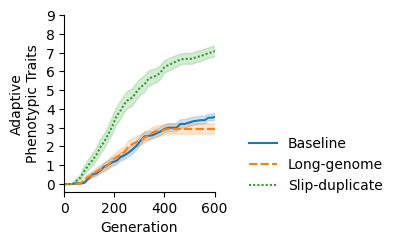

teeplots/adaptive-evolution-rate.ipynb/errorbar=ci+hue=treatment+kind=line+mutation=poisson+style=treatment+viz=relplot+x=generation+y=has-task+ext=.pdf
teeplots/adaptive-evolution-rate.ipynb/errorbar=ci+hue=treatment+kind=line+mutation=poisson+style=treatment+viz=relplot+x=generation+y=has-task+ext=.png


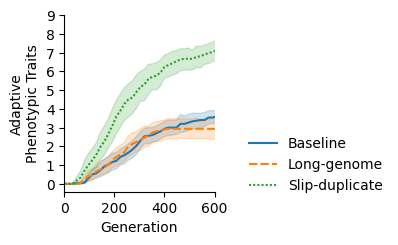

teeplots/adaptive-evolution-rate.ipynb/errorbar=se+hue=treatment+kind=line+mutation=per site+style=treatment+viz=relplot+x=generation+y=has-task+ext=.pdf
teeplots/adaptive-evolution-rate.ipynb/errorbar=se+hue=treatment+kind=line+mutation=per site+style=treatment+viz=relplot+x=generation+y=has-task+ext=.png


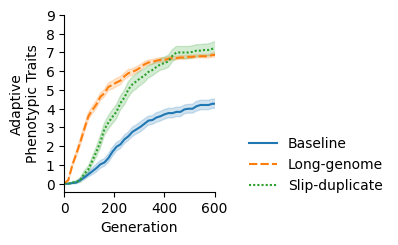

teeplots/adaptive-evolution-rate.ipynb/errorbar=ci+hue=treatment+kind=line+mutation=per site+style=treatment+viz=relplot+x=generation+y=has-task+ext=.pdf
teeplots/adaptive-evolution-rate.ipynb/errorbar=ci+hue=treatment+kind=line+mutation=per site+style=treatment+viz=relplot+x=generation+y=has-task+ext=.png


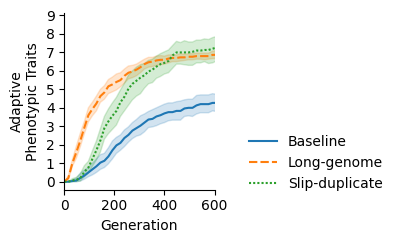

In [12]:
for mutation, errorbar in it.product(
    dfz_["mutation"].unique(),
    ["se", "ci"],
):
    dftmp = dfz_[
        (dfz_["Generation"] % 16 == 0)
        & (dfz_["mutation"] == mutation)
    ].reset_index()
    dftmp["Treatment"] = dftmp["Treatment"].map(
        {
            "Slip-": "Baseline",
            "Slip-_Long": "Long-genome",
            "Slip+": "Slip-duplicate",
            "Baseline-Treatment": "Baseline",
            "Long-Ancestor-Control-Treatment": "Long-genome",
            "Slip-duplicate": "Slip-duplicate",
        },
    )
    dftmp["Task Complexity"] = dftmp["Components"]
    dftmz = dftmp.groupby(
        ["Run ID", "Generation", "Treatment", "mutation"]
    ).agg("sum").reset_index()
    with tp.teed(
        sns.relplot,
        data=dftmz,
        x="Generation",
        y="Has Task",
        hue="Treatment",
        hue_order=["Baseline", "Long-genome", "Slip-duplicate"],
        style="Treatment",
        style_order=["Baseline", "Long-genome", "Slip-duplicate"],
        aspect=1.0,
        height=2.5,
        kind="line",
        errorbar=errorbar,
        facet_kws=dict(margin_titles=True),
        teeplot_subdir=teeplot_subdir,
        teeplot_outattrs={"mutation": mutation},
    ) as g:
        g.set(
            ylabel="Adaptive\nPhenotypic Traits",
            xlim=(0, 600),
            xticks=[*range(0, 601, 200)],
            yticks=[*range(0, 10)],
        )
        g.set_titles(col_template="Task Complexity\nMin {col_name} NAND")
        sns.move_legend(
            g, "lower center",
            bbox_to_anchor=(0.85, 0.18), ncol=1, title=None, frameon=False,
        )


/tmp/ipykernel_3831/2201856195.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="left")


teeplots/adaptive-evolution-rate.ipynb/hue=treatment+inner=box+kind=violin+mutation=poisson+viz=catplot+x=treatment+y=has-task+ext=.pdf
teeplots/adaptive-evolution-rate.ipynb/hue=treatment+inner=box+kind=violin+mutation=poisson+viz=catplot+x=treatment+y=has-task+ext=.png


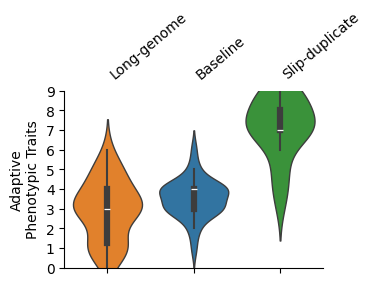

/tmp/ipykernel_3831/2201856195.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="left")


teeplots/adaptive-evolution-rate.ipynb/hue=treatment+inner=box+kind=violin+mutation=per site+viz=catplot+x=treatment+y=has-task+ext=.pdf
teeplots/adaptive-evolution-rate.ipynb/hue=treatment+inner=box+kind=violin+mutation=per site+viz=catplot+x=treatment+y=has-task+ext=.png


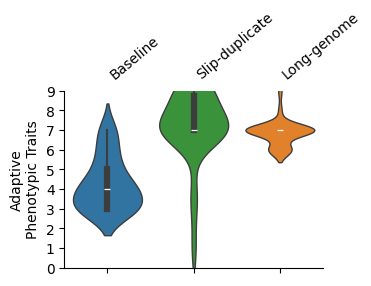

In [13]:
for mutation in dfz_["mutation"].unique():
    dftmp = dfz_[
        (dfz_["Generation"] == 600)
        & (dfz_["mutation"] == mutation)
    ].reset_index()
    dftmp["Treatment"] = dftmp["Treatment"].map(
        {
            "Slip-": "Baseline",
            "Slip-_Long": "Long-genome",
            "Slip+": "Slip-duplicate",
            "Baseline-Treatment": "Baseline",
            "Long-Ancestor-Control-Treatment": "Long-genome",
            "Slip-duplicate": "Slip-duplicate",
        },
    )
    dftmp["Task Complexity"] = dftmp["Components"]
    dftmz = dftmp.groupby(
        ["Run ID", "Generation", "Treatment", "mutation"]
    ).agg("sum").reset_index()
    # print(dftmz)
    with tp.teed(
        sns.catplot,
        data=dftmz,
        y="Has Task",
        hue="Treatment",
        x="Treatment",
        kind="violin",
        aspect=1.4,
        height=2.5,
        inner="box",
        linewidth=1,
        hue_order=["Baseline", "Long-genome", "Slip-duplicate"],
        teeplot_subdir=teeplot_subdir,
        teeplot_outattrs={"mutation": mutation},
    ) as g:
        ax, = g.axes.flat
        # Core lines for your request:
        ax.xaxis.set_ticks_position("bottom")
        ax.xaxis.set_label_position("top")
        ax.tick_params(axis="x", labelbottom=False, labeltop=True)
        ax.set_ylabel("Adaptive\nPhenotypic Traits")
        ax.set_xlabel("")
        ax.set_yticks(np.arange(0, 10, 1))
        ax.set_ylim(0, 9)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="left")


/home/runner/.local/lib/python3.12/site-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=se+hue=treatment+kind=line+mutation=poisson+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.pdf, overwriting it
  warnings.warn(


teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=se+hue=treatment+kind=line+mutation=poisson+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.pdf


/home/runner/.local/lib/python3.12/site-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=se+hue=treatment+kind=line+mutation=poisson+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.png, overwriting it
  warnings.warn(


teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=se+hue=treatment+kind=line+mutation=poisson+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.png


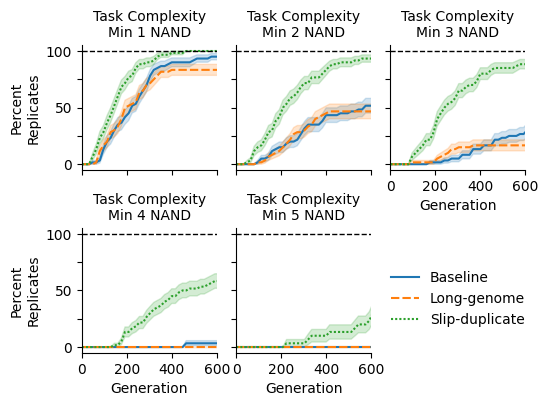

/home/runner/.local/lib/python3.12/site-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=ci+hue=treatment+kind=line+mutation=poisson+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.pdf, overwriting it
  warnings.warn(


teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=ci+hue=treatment+kind=line+mutation=poisson+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.pdf


/home/runner/.local/lib/python3.12/site-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=ci+hue=treatment+kind=line+mutation=poisson+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.png, overwriting it
  warnings.warn(


teeplots/adaptive-evolution-rate.ipynb/col=task-complexity+errorbar=ci+hue=treatment+kind=line+mutation=poisson+post=plt-xlim-0-600+style=treatment+viz=relplot+x=generation+y=has-task+ext=.png


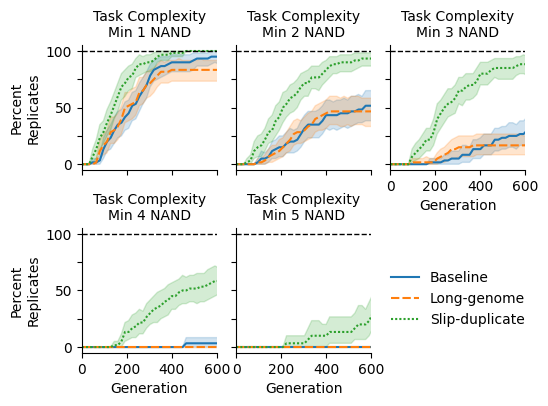

In [14]:
dftmp = dfz_[
    (dfz_["Generation"] % 16 == 0)
    & (dfz_["mutation"] == "poisson")
].reset_index()
dftmp["Treatment"] = dftmp["Treatment"].map(
    {
        "Slip-": "Baseline",
        "Slip-_Long": "Long-genome",
        "Slip+": "Slip-duplicate",
    },
)
dftmp["Task Complexity"] = dftmp["Components"]
dftmp["Has Task"] *= 100
for errorbar in ["se", "ci"]:
    with tp.teed(
        sns.relplot,
        data=dftmp,
        col="Task Complexity",
        x="Generation",
        y="Has Task",
        hue="Treatment",
        hue_order=["Baseline", "Long-genome", "Slip-duplicate"],
        style="Treatment",
        style_order=["Baseline", "Long-genome", "Slip-duplicate"],
        aspect=0.9,
        height=2,
        col_wrap=3,
        kind="line",
        errorbar=errorbar,
        facet_kws=dict(margin_titles=True),
        teeplot_postprocess="plt.xlim(0, 600)",
        teeplot_subdir=teeplot_subdir,
        teeplot_outattrs={"mutation": "poisson"},
    ) as g:
        g.set(
            ylabel="Percent\nReplicates",
            yticks=[0, 25, 50, 75, 100],
            yticklabels=["0", "", "50", "", "100"],
        )
        g.set_titles(col_template="Task Complexity\nMin {col_name} NAND")
        for ax in g.axes.flat:
            ax.axhline(100.0, color="black", linewidth=1, linestyle="--")
        sns.move_legend(
            g, "lower center",
            bbox_to_anchor=(0.68, 0.18), ncol=1, title=None, frameon=False,
        )
        kind="violin",


In [15]:
fil = dfz_[
    (dfz_["Generation"] == 599)
    & dfz_["Treatment"].isin(["Baseline-Treatment", "Slip-duplicate"])
]

for task in fil["Task"].unique():
    tab = [
        [
            (
                (fil["Treatment"] == "Baseline-Treatment")
                & (fil["Task"] == task)
                & fil["Has Task"]
            ).sum(),
            (
                (fil["Treatment"] == "Slip-duplicate")
                & (fil["Task"] == task)
                & fil["Has Task"]
            ).sum(),
        ],
        [
            (
                (fil["Treatment"] == "Baseline-Treatment")
                & (fil["Task"] == task)
                & (~fil["Has Task"])
            ).sum(),
            (
                (fil["Treatment"] == "Slip-duplicate")
                & (fil["Task"] == task)
                & (~fil["Has Task"])
            ).sum(),
        ],
    ]
    print(task, tab)
    print("    ", scipy.stats.fisher_exact(tab))


ORNOT [[np.int64(29), np.int64(29)], [np.int64(1), np.int64(1)]]
     SignificanceResult(statistic=np.float64(1.0), pvalue=1.0)
XOR [[np.int64(0), np.int64(9)], [np.int64(30), np.int64(21)]]
     SignificanceResult(statistic=np.float64(0.0), pvalue=np.float64(0.0019356033191389086))
AND [[np.int64(8), np.int64(27)], [np.int64(22), np.int64(3)]]
     SignificanceResult(statistic=np.float64(0.04040404040404041), pvalue=np.float64(9.502531508333732e-07))
ANDNOT [[np.int64(11), np.int64(27)], [np.int64(19), np.int64(3)]]
     SignificanceResult(statistic=np.float64(0.06432748538011696), pvalue=np.float64(3.324669067805032e-05))
OR [[np.int64(16), np.int64(28)], [np.int64(14), np.int64(2)]]
     SignificanceResult(statistic=np.float64(0.08163265306122448), pvalue=np.float64(0.0009098128565499235))
NAND [[np.int64(30), np.int64(29)], [np.int64(0), np.int64(1)]]
     SignificanceResult(statistic=inf, pvalue=1.0)
NOR [[np.int64(4), np.int64(27)], [np.int64(26), np.int64(3)]]
     SignificanceR

In [16]:
fil = dfz_[
    (dfz_["Generation"] == 599)
    & dfz_["Treatment"].isin(["Long-Ancestor-Control-Treatment", "Slip-duplicate"])
]

for task in fil["Task"].unique():
    tab = [
        [
            (
                (fil["Treatment"] == "Long-Ancestor-Control-Treatment")
                & (fil["Task"] == task)
                & fil["Has Task"]
            ).sum(),
            (
                (fil["Treatment"] == "Slip-duplicate")
                & (fil["Task"] == task)
                & fil["Has Task"]
            ).sum(),
        ],
        [
            (
                (fil["Treatment"] == "Long-Ancestor-Control-Treatment")
                & (fil["Task"] == task)
                & (~fil["Has Task"])
            ).sum(),
            (
                (fil["Treatment"] == "Slip-duplicate")
                & (fil["Task"] == task)
                & (~fil["Has Task"])
            ).sum(),
        ],
    ]
    print(task, tab)
    print("    ", scipy.stats.fisher_exact(tab))


NOR [[np.int64(22), np.int64(27)], [np.int64(8), np.int64(3)]]
     SignificanceResult(statistic=np.float64(0.3055555555555556), pvalue=np.float64(0.18058040377378293))
NOT [[np.int64(30), np.int64(30)], [np.int64(0), np.int64(0)]]
     SignificanceResult(statistic=nan, pvalue=1.0)
XOR [[np.int64(2), np.int64(9)], [np.int64(28), np.int64(21)]]
     SignificanceResult(statistic=np.float64(0.16666666666666666), pvalue=np.float64(0.04190011890841874))
OR [[np.int64(30), np.int64(28)], [np.int64(0), np.int64(2)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(0.4915254237288135))
AND [[np.int64(30), np.int64(27)], [np.int64(0), np.int64(3)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(0.23728813559322032))
ORNOT [[np.int64(30), np.int64(29)], [np.int64(0), np.int64(1)]]
     SignificanceResult(statistic=inf, pvalue=1.0)
NAND [[np.int64(30), np.int64(29)], [np.int64(0), np.int64(1)]]
     SignificanceResult(statistic=inf, pvalue=1.0)
ANDNOT [[np.int64(30), np.int64(27

In [17]:
fil = dfz_[
    (dfz_["Generation"] == 599)
]

for components in sorted(fil["Components"].unique()):
    tab = [
        [
            (
                (fil["Treatment"] == "Long-Ancestor-Control-Treatment")
                & (fil["Components"] == components)
                & fil["Has Task"]
            ).sum(),
            (
                (fil["Treatment"] == "Slip-duplicate")
                & (fil["Components"] == components)
                & fil["Has Task"]
            ).sum(),
        ],
        [
            (
                (fil["Treatment"] == "Long-Ancestor-Control-Treatment")
                & (fil["Components"] == components)
                & (~fil["Has Task"])
            ).sum(),
            (
                (fil["Treatment"] == "Slip-duplicate")
                & (fil["Components"] == components)
                & (~fil["Has Task"])
            ).sum(),
        ],
    ]
    print(components, tab)
    print("    ", scipy.stats.fisher_exact(tab))


1 [[np.int64(60), np.int64(59)], [np.int64(0), np.int64(1)]]
     SignificanceResult(statistic=inf, pvalue=1.0)
2 [[np.int64(60), np.int64(56)], [np.int64(0), np.int64(4)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(0.11872441284205987))
3 [[np.int64(60), np.int64(55)], [np.int64(0), np.int64(5)]]
     SignificanceResult(statistic=inf, pvalue=np.float64(0.057315233785822026))
4 [[np.int64(24), np.int64(36)], [np.int64(36), np.int64(24)]]
     SignificanceResult(statistic=np.float64(0.4444444444444444), pvalue=np.float64(0.04416559968491914))
5 [[np.int64(2), np.int64(10)], [np.int64(28), np.int64(20)]]
     SignificanceResult(statistic=np.float64(0.14285714285714285), pvalue=np.float64(0.0211452463435343))
